In [2]:
import nltk
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger_eng');
nltk.download('wordnet');
nltk.download('sentiwordnet');
nltk.download('movie_reviews');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sambr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sambr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sambr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\sambr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sambr\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Pràctica 2: Detecció d'opinions 

Aquesta pràctica consisteix en generar un model que detecti les opinions de diverses crítiques de polítiques. És a dir, Que puguir afirmar què l'usuari dona un bon comentari o una crítica negativa a una pel·lícula. Aquesta pràctica es divideix en dos subapartats. El primer consisteix en generar un model supervisat, és a dir, un model que requereix un conjunt d'entrenament per a funcionar. Mentres que al segon no li cal. 

## Dividir en conjunt de test i train

Abans de començar a entrenar models, cal preprocessar les dades. En aquest cas, només cal passar el text a minúscula, eliminar els signes de puntuació i els stopwords

In [4]:
from nltk.corpus import movie_reviews as mr;
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() # lowercase
    #text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\n', ' ', text) # remove new lines
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the text and remove stop words
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens) # return the text as string

Després del preprocessat, només cal separar les dades en un conjunt d'entrenament i un de test. El conjunt d'entrenament només s'utilitzarà per els models supervisats, ja que el model no-supervisat no li cal cap entrenament, així que les validacions dels models es faràn només amb el conjunt de test.

In [5]:
fileids = mr.fileids()
categories = [mr.categories(fileid)[0] for fileid in fileids]  # 'pos' or 'neg'

data = pd.DataFrame({
    'text': [preprocess(mr.raw(fileid)) for fileid in fileids],   #Preprocess the text before creating the df
    'label': categories
})

# Split into train and test with stratify to balance categories
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

display(data.head())
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

,text,label
0,plot two teen couple go church party drink dri...,neg
1,happy bastard quick movie review damn y2k bug ...,neg
2,movie like make jaded movie viewer thankful in...,neg
3,quest camelot warner bros first featurelength ...,neg
4,synopsis mentally unstable man undergoing psyc...,neg


Train size: 1600
Test size: 400


Per els conjunts dels models supervisats, els hi cal aplicar el CountVectorizer, que converteix els textos en una matriu que compta el nombre de vegades que apareix un token, per així poder ser utilitzats pels models.

In [6]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train).astype(np.float32)
X_test_vectorized = vectorizer.transform(X_test).astype(np.float32)

## Secció 1: Aprenentatge supervisat

Els models d'aquesta secció utilitzen un algoritme per aprendre a partir d'un cojunt d'entrenament com es diferencien les opinions positives de les negatives. Hem seleccionat diversos models de scikit-learn i els hem posat a prova, optimitzant els seus hiperparàmetres per observar quin model retorna la millor precisió. En aquesta pràctica, els models que hem utilitzat són la regressió logística, KNN, Random Forest, SVC i SVM.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Definir modelos con random_state donde sea aplicable
random_state = 42
logr = LogisticRegression(random_state=random_state)  # Aumentar max_iter para convergencia
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=random_state)
lgbm = LGBMClassifier(random_state=random_state, verbose=-1)
svm = SVC(random_state=random_state)

# Definir los grids de hiperparámetros para cada modelo
logr_params = {
    'max_iter': [1000],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

lgbm_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31], 
}

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [8]:
models = [
    ('Logistic Regression', logr, logr_params),
    ('KNN', knn, knn_params),
    ('Random Forest', rf, rf_params),
    ('LightGBM', lgbm, lgbm_params),
    ('SVM', svm, svm_params)
]

best_params = {}
best_scores = {}

for name, model, params in models:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=2)

    grid_search.fit(X_train_vectorized, y_train)

    best_params[name] = grid_search.best_params_
    best_scores[name] = grid_search.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [9]:
results_df = pd.DataFrame({
    'Model': list(best_scores.keys()),
    'Best Score': list(best_scores.values()),
    'Best Parameters': list(best_params.values())})

results_df = results_df.sort_values('Best Score', ascending=False)

display(results_df)

,Model,Best Score,Best Parameters
0,Logistic Regression,0.836875,"{'C': 0.1, 'max_iter': 1000, 'solver': 'liblin..."
2,Random Forest,0.830625,"{'max_depth': 10, 'max_features': 'sqrt', 'min..."
4,SVM,0.823750,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
3,LightGBM,0.819375,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
1,KNN,0.570625,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei..."


Tots el models excepte el KNN han donat resultats de precisió relativament similars (emplenar aquí Sergi...).
El model de KNN ha donat un resultat molt pitjor en comparació amb els altres, possiblement pels mètodes que utilitza per calcular distàncies entre veïns, ja que la majoria tenen o valor 1 o 0.

## Evaluar els models en el test

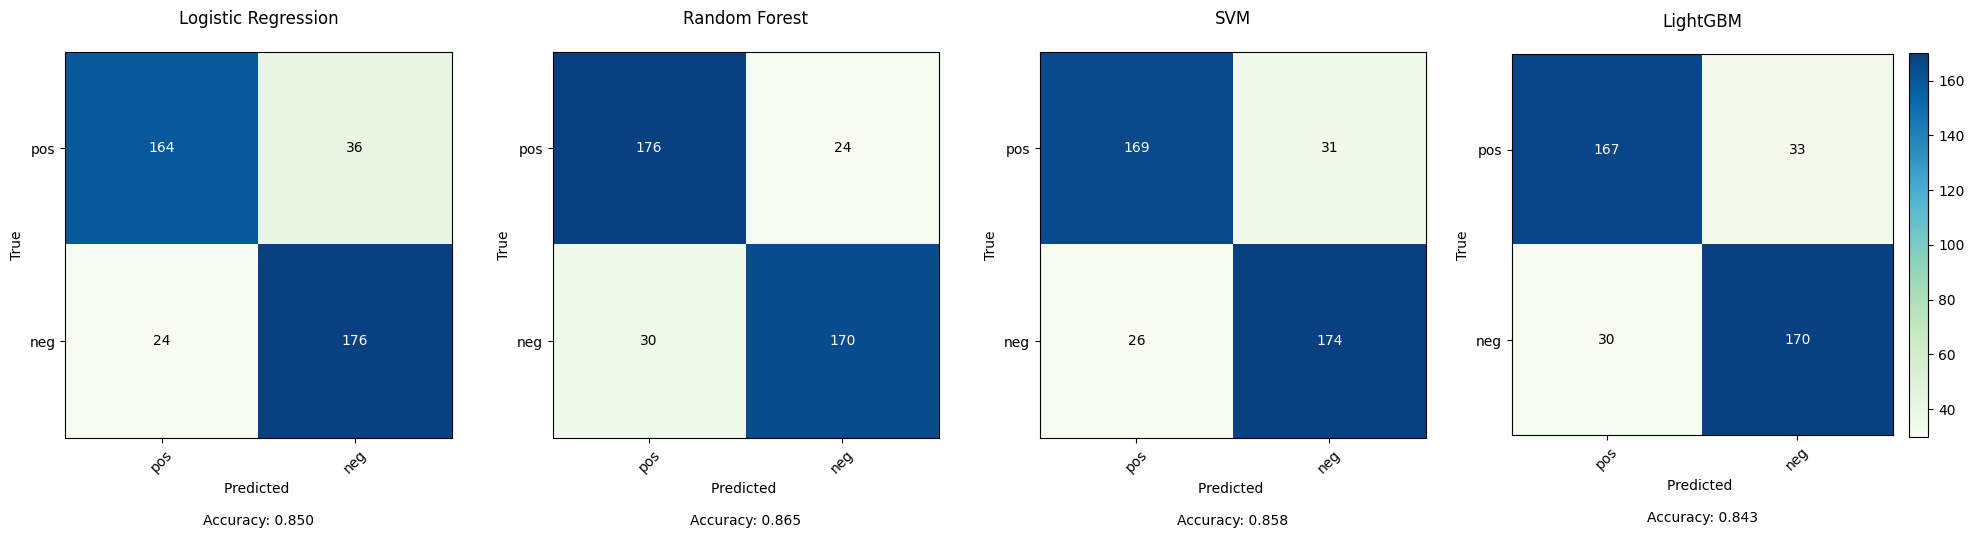

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

results_filtered = results_df[results_df['Best Score'] > 0.7]
n_models = len(results_filtered) 
plt.figure(figsize=(5 * n_models, 5))  # 

for idx, (index, row) in enumerate(results_filtered.iterrows(), 1):
    model_name = row['Model']
    model_params = best_params[model_name]

    # Train models with best hyperparameters
    model = next(model for name, model, params in models if name == model_name)
    model.set_params(**model_params)

    # Train and predict
    model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(1, n_models, idx)
    im = ax.imshow(conf_matrix, cmap='GnBu') 
    ax.set_title(f"{model_name}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel(f'Predicted \n\nAccuracy: {accuracy:.3f}')
    ax.set_ylabel('True')
    
    # Cell text
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
            
# Add colorbar only for the fourth plot
if idx == 4:
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


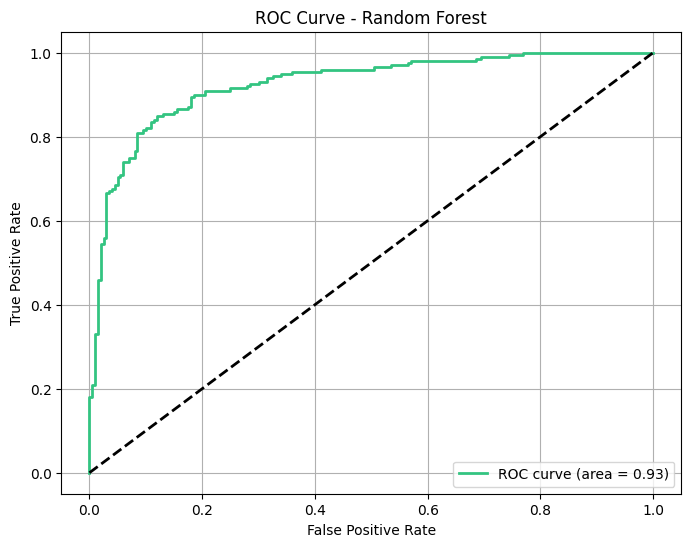

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain probabilities for the positive class
rf = RandomForestClassifier(random_state=random_state)
rf.set_params(**best_params['Random Forest'])
rf.fit(X_train_vectorized, y_train)
y_pred_roc = rf.predict_proba(X_test_vectorized)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc, pos_label='pos')
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#33C481', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## No supervisada

In [12]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn

def get_wordnet_category(pos):
    wdnet_pos = None
    if pos.startswith('J'):
        wdnet_pos = wn.ADJ
    elif pos.startswith('N'):
        wdnet_pos = wn.NOUN
    elif pos.startswith('R'):
        wdnet_pos = wn.ADV
    elif pos.startswith('V'):
        wdnet_pos = wn.VERB
    return wdnet_pos

def sentiment_classifier(text, categories={'a', 'n', 'r', 'v', 's'}):
    pos_score, neg_score = 0, 0

    word_tokenize_list = word_tokenize(text)
    tagged_words = nltk.pos_tag(word_tokenize_list)

    for word, pos in tagged_words:
        wdnet_pos = get_wordnet_category(pos)

        if categories is None or wdnet_pos in categories:
            synset = lesk(word_tokenize_list, word, wdnet_pos)

            if synset is None and wdnet_pos == wn.ADJ and 's' in categories:
                synset = lesk(word_tokenize_list, word, wn.ADJ_SAT)
            
            if synset is not None:
                swn_synset = swn.senti_synset(synset.name())
                pos_score += swn_synset.pos_score()
                neg_score += swn_synset.neg_score()
    
    return 'pos' if pos_score >= neg_score else 'neg'

In [13]:
from itertools import combinations

# Get a sample of the test set to speed up the process
sample_size = 250
X_test_sample = X_test.sample(sample_size, random_state=random_state)
y_test_sample = y_test[X_test_sample.index]
top_combinations = []
best_accuracy = 0

# Generate all possible combinations of categories
categories_set = {'a', 'n', 'r', 'v', 's'}
all_combinations = []
for i in range(1, len(categories_set) + 1):
    all_combinations.extend(combinations(categories_set, i))

for comb in all_combinations:
    X_test_sentiment_sample = X_test_sample.apply(lambda x: sentiment_classifier(x, categories=comb))
    accuracy = accuracy_score(y_test_sample, X_test_sentiment_sample)
    top_combinations.append((comb, accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_combination = comb

top_combinations = sorted(top_combinations, key=lambda x: x[1], reverse=True)
print(f"\nBest Combination: {top_combinations[0][0]}, Best Accuracy: {top_combinations[0][1]:.4f}")


Best Combination: ('s', 'r', 'a'), Best Accuracy: 0.6360


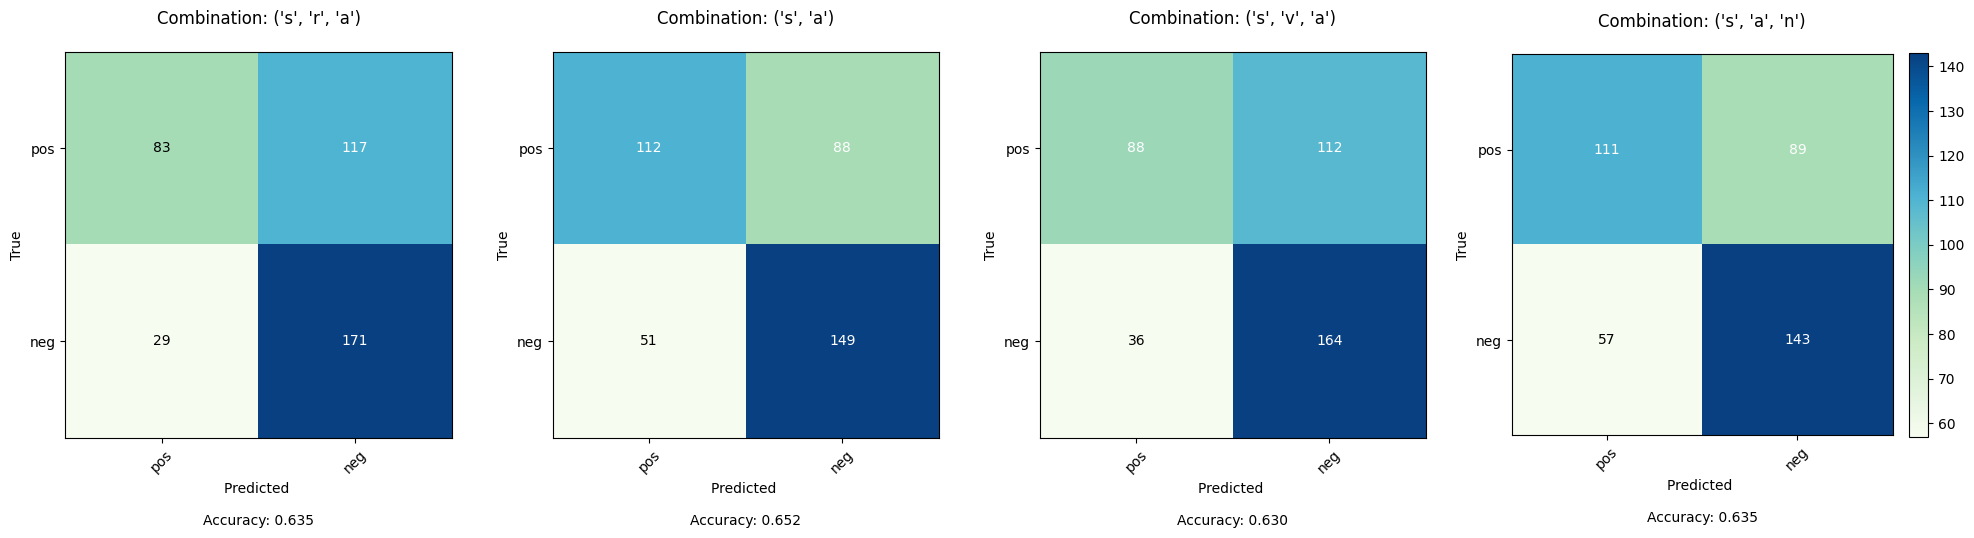

In [14]:
n_models = 4
plt.figure(figsize=(5 * n_models, 5))

for idx, (comb, _) in enumerate(top_combinations[:n_models], 1):
    # Calculate predictions
    y_pred = X_test.apply(lambda x: sentiment_classifier(x, categories=set(comb)))

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(1, n_models, idx)
    im = ax.imshow(conf_matrix, cmap='GnBu')
    ax.set_title(f"Combination: {comb}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel(f'Predicted \n\nAccuracy: {accuracy:.3f}')
    ax.set_ylabel('True')

    # Add cell text
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    # Add colorbar only for the fourth plot
    if idx == 4:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
from scipy import sparse

# Get a sample of 50 elements from X_train_vectorized

# Sample 50 rows randomly using the same random state for consistency
sample_indices = np.random.RandomState(random_state).choice(X_train_vectorized.shape[0], size=50, replace=False)
X_train_sample_50 = X_train_vectorized[sample_indices]

# Display information about the sample
print(f"Sample shape: {X_train_sample_50.shape}")
print(f"Sample sparsity: {X_train_sample_50.nnz / (X_train_sample_50.shape[0] * X_train_sample_50.shape[1]) * 100:.4f}%")
print(f"Number of non-zero elements: {X_train_sample_50.nnz}")

# Get corresponding labels
y_train_sample_50 = y_train.iloc[sample_indices]
print(f"Class distribution in sample: {y_train_sample_50.value_counts().to_dict()}")

## Comparative Supervised vs Unsupervised

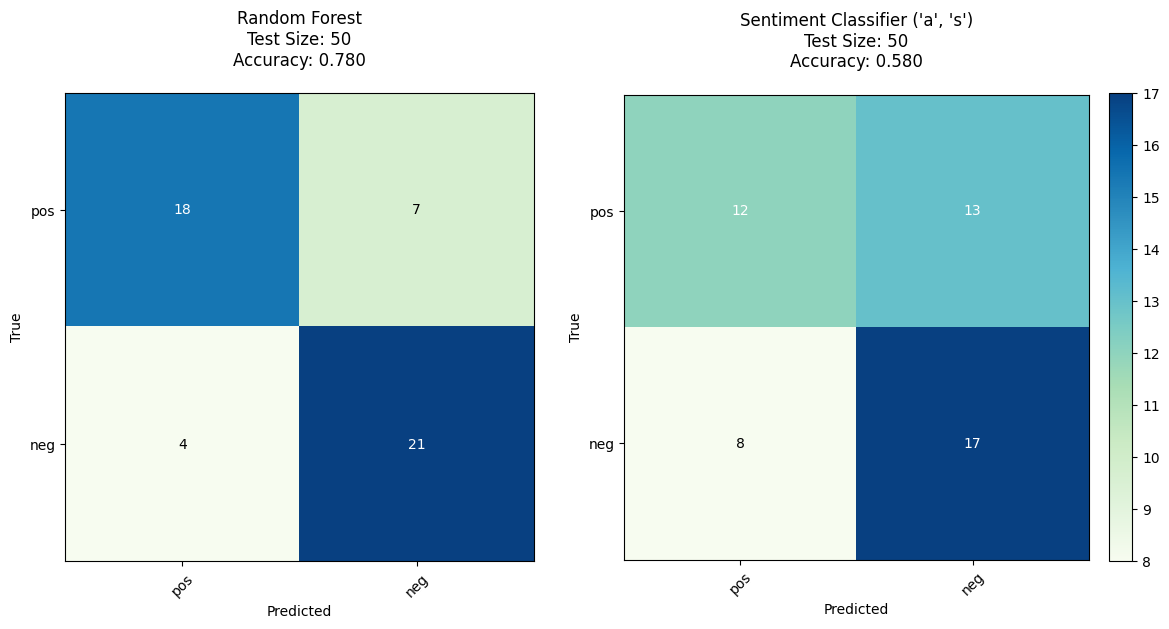

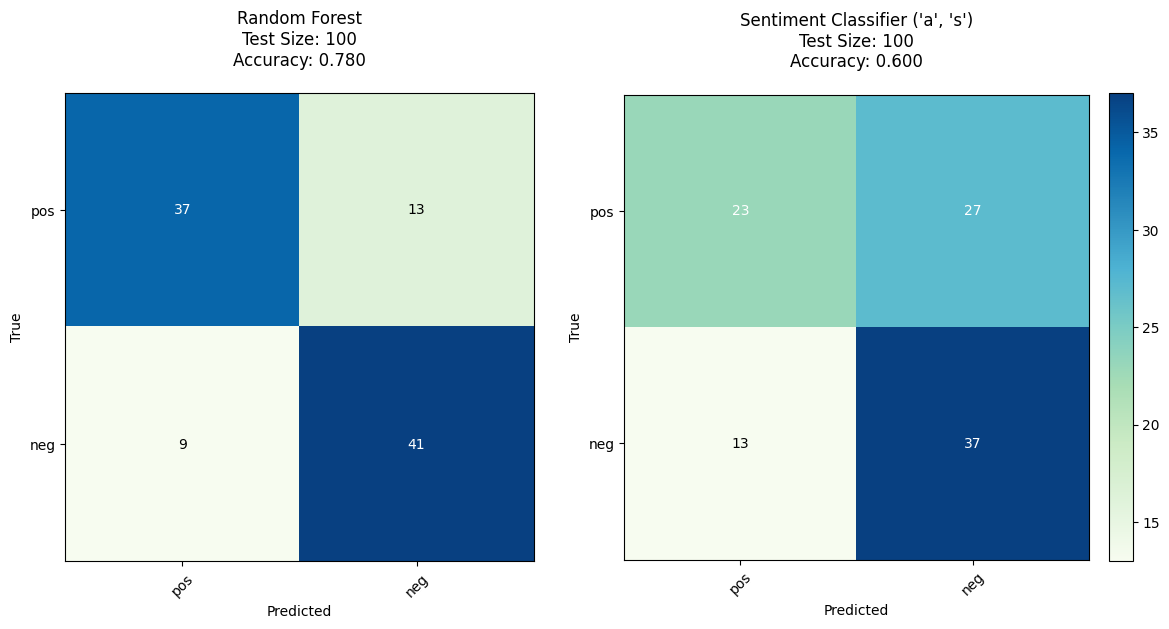

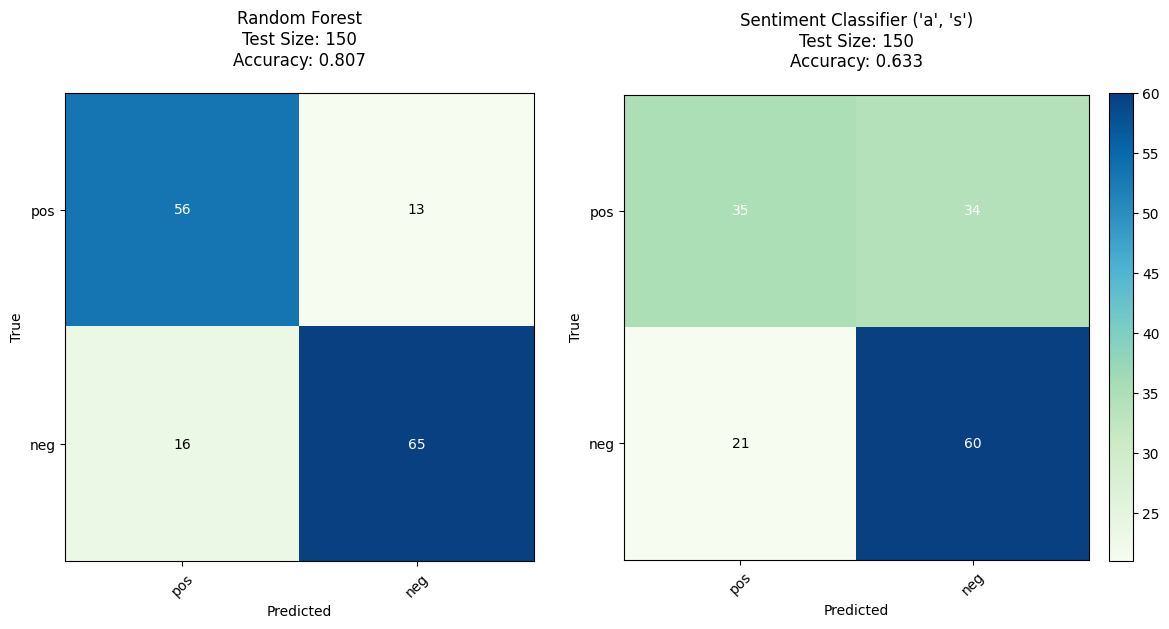

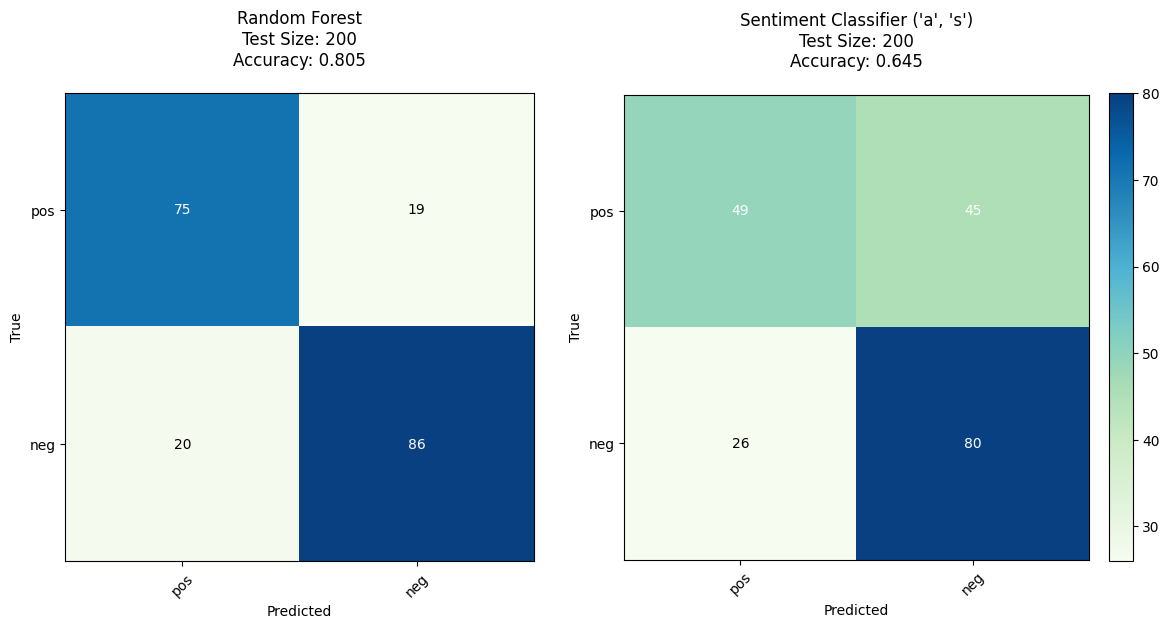

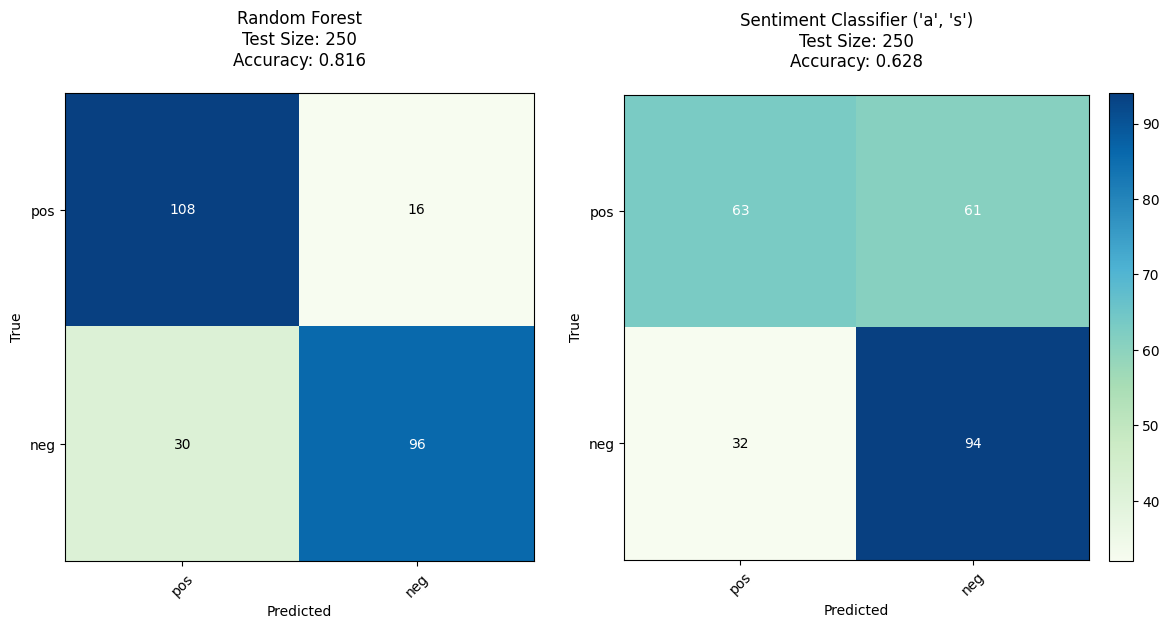

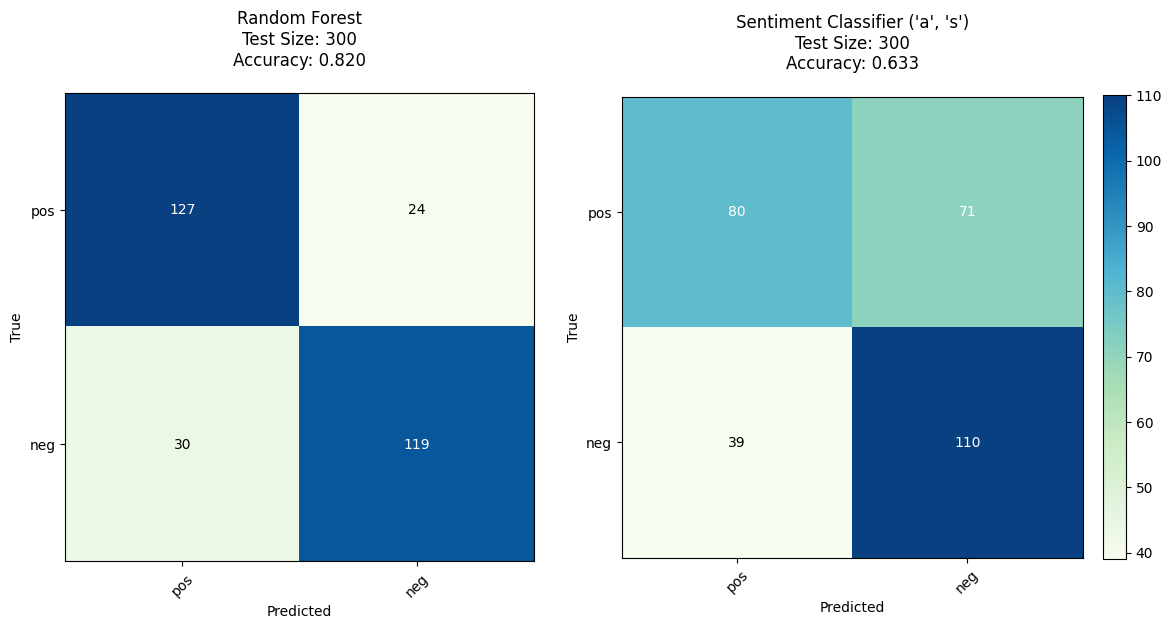

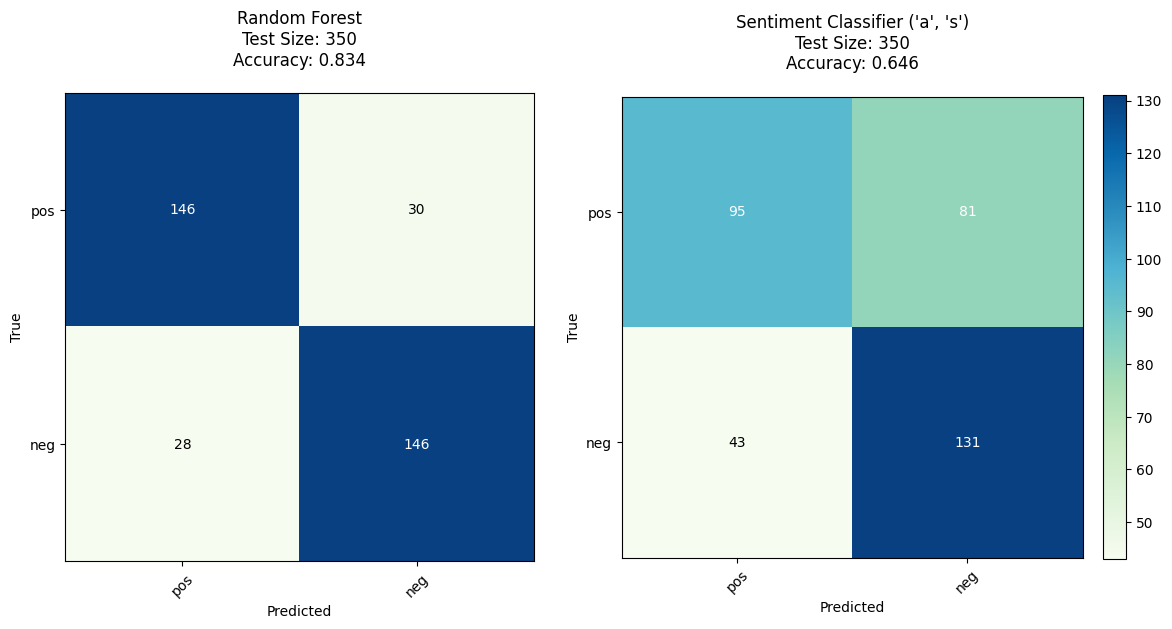

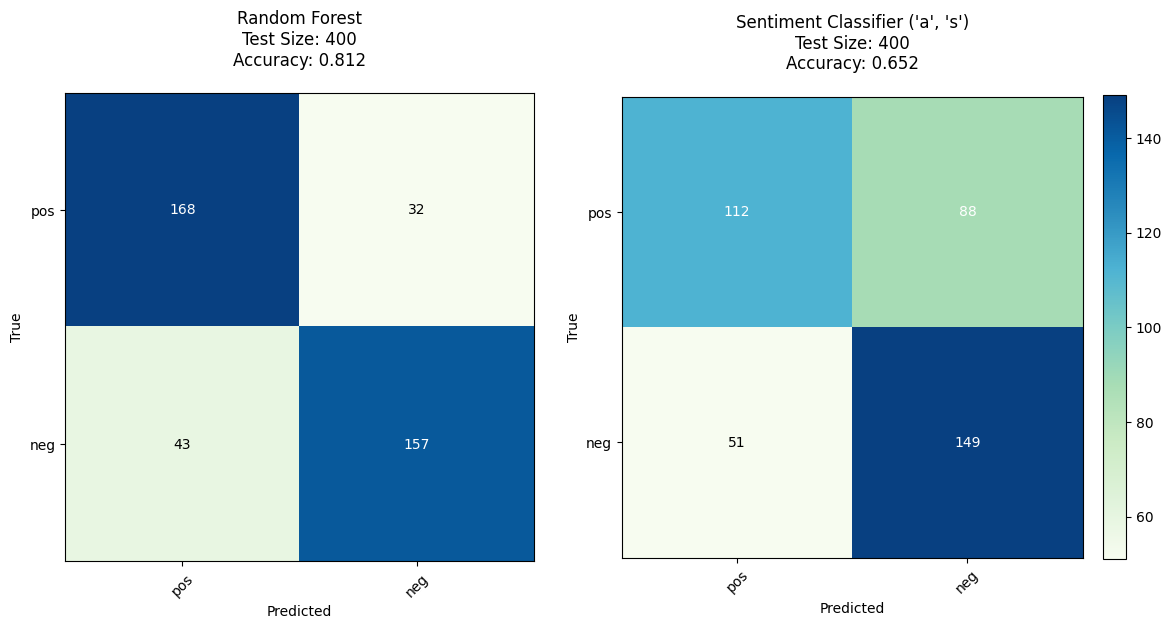

In [27]:
for mida in range(50, 401, 50):
    sample_indices_test = np.random.RandomState(random_state).choice(X_test.shape[0], size=mida, replace=False)

    X_test_sample = X_test.iloc[sample_indices_test]
    y_test_sample = y_test.iloc[sample_indices_test]
    
    # Vectorize the test sample
    X_test_sample_vectorized = vectorizer.transform(X_test_sample).astype(np.float32)

    sample_indices_train = np.random.RandomState(random_state).choice(X_train_vectorized.shape[0], size=mida*4, replace=False)

    X_train_sample = X_train_vectorized[sample_indices_train]
    y_train_sample = y_train.iloc[sample_indices_train]
    # Train Random Forest and predict
    rf = RandomForestClassifier(random_state=random_state, **best_params['Random Forest'])
    rf.fit(X_train_sample, y_train_sample)
    y_pred_rf = rf.predict(X_test_sample_vectorized)
    # Predict with sentiment classifier
    y_pred_sentiment = X_test_sample.apply(lambda x: sentiment_classifier(x, categories={'a', 's'}))
    #y_pred_rf = rf.predict(X_test_sample)
    # Predict with sentiment classifier
    #y_pred_sentiment = X_test_sample.apply(lambda x: sentiment_classifier(x, categories={'a', 's'}))

    # Confusion matrices
    conf_matrices = [
        (confusion_matrix(y_test_sample, y_pred_rf), "Random Forest", accuracy_score(y_test_sample, y_pred_rf)),
        (confusion_matrix(y_test_sample, y_pred_sentiment),
        "Sentiment Classifier ('a', 's')", accuracy_score(y_test_sample, y_pred_sentiment))
    ]

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, (conf_matrix, title, accuracy) in zip(axes, conf_matrices):
        im = ax.imshow(conf_matrix, cmap='GnBu')
        ax.set_title(f"{title}\nTest Size: {mida}\nAccuracy: {accuracy:.3f}", pad=20)
        ax.set_xticks(np.arange(len(set(y_test_sample))), labels=set(y_test_sample), rotation=45)
        ax.set_yticks(np.arange(len(set(y_test_sample))), labels=set(y_test_sample))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(j, i, conf_matrix[i, j], ha="center", va="center",
                        color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
                
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()